# Titianic Kaggale

## Link: [Kaggle](https://www.kaggle.com/c/titanic)


## Loading Libraries

In [56]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import random
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
%matplotlib inline

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing 

from sklearn.model_selection import train_test_split
from sklearn import metrics

#extra My libs
CSI   = "\x1B["
import sys
sys.path.append("../src")
from MyData import *
from MySklearn import *
from MyXGboost import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [16]:
## head
#Train.head(10)
# '''
# Variable	Definition	Key
# survival	Survival	0 = No, 1 = Yes
# pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
# sex	Sex	
# Age	Age in years	
# sibsp	# of siblings / spouses aboard the Titanic	
# parch	# of parents / children aboard the Titanic	
# ticket	Ticket number	
# fare	Passenger fare	
# cabin	Cabin number	
# embarked	Port of Embarkation
# '''

In [17]:
# Load in the train and test datasets
Train = pd.read_csv('Data/train.csv')
Test  = pd.read_csv('Data/test.csv')

# Store our passenger ID for easy access
PassengerId = Test['PassengerId']

## Data Inspection

In [18]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Given the data nature, a few points have to be made
#### Class seperate information a lot --  first class should be seperated as a different classifier from the other two; because only first class have most cabin information
#### Also, we know as a fact that woman and children are treated differently; they should have a different classifier as well;


* P1,2; Female should be a subclass itself; 95% survival; 170 data
* P3; Female should be a subclass; 50%; 122 data
* P1; Male should be a subclass; 36%; 144 data
* P2, 3; Male should be a subclass; 18%; 405 data

In [19]:
print (Train.loc[(Train["Pclass"] == 1)][['Sex', 'Survived']].groupby(['Sex'], as_index=False).count())
Train.loc[(Train["Pclass"] == 1) & (Train["Sex"] == "female")  & (Train["Survived"] == 0)]
# Train['COUNTER'] =1       #initially, set that counter to 1.
# group_data = Train.groupby(['Pclass', 'Sex'])['COUNTER'].sum() #sum function
# print(group_data)
#Test['COUNTER'] =1       #initially, set that counter to 1.
#group_data = Test.groupby(['Pclass', 'Sex'])['COUNTER'].sum() #sum function
#print(group_data)
#print (Train[['Pclass', 'Sex']].groupby(['Pclass'], as_index=False).count())
#print (Train[['Pclass', 'Sex']].groupby(['Sex'], as_index=False).count())

      Sex  Survived
0  female        94
1    male       122


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
177,178,0,1,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,C22 C26,S


In [20]:
#Train["Survived"][Train["Age"].isnull()]
#null_columns=Train.columns[Train.isnull().any()]
#print(null_columns)
#print(Train[Train["Age"].isnull()][["Survived", "Pclass"]])
#null_columns=Test.columns[Test.isnull().any()]
#print(null_columns)
#print(Test[Test["Cabin"].isnull()][["Sex", "Pclass"]])
#print(Test[Test.isnull().any(axis=1)][null_columns])
#print(Train["Survived"][Train["Age"].any(axis=1)].head())

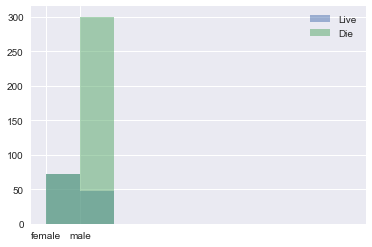

In [21]:
#print(Train.columns, test.columns)
#print (Test[['Pclass', 'Sex']].groupby(['Pclass'], as_index=False).count())
#print (Train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
#print (Train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
#print (Train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean())
#print (Train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean())
#print (Train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean())
#print (Train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean())
#print (Train[["Cabin", "Survived"]].groupby(['Cabin'], as_index=False).mean())
plt.clf()
pltstr, pltrange = ("Sex", np.arange(0, 10, 1))
#Train['CabinNumber'] = Train['Cabin'].fillna("Z0").apply(lambda x: int(x.split(" ")[0][1:] + "0")/10)
#Train['CabinClass'] = Train['Cabin'].fillna("Z0").apply(lambda x: x.replace(" ", "")[0])
#Train['CabinClass'] = Train['CabinClass'].map( {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E':4, 'F':5, "G":6, "T":7, "Z":8}).astype(int)
Train.loc[(Train['Survived'] == 1) & (Train["Pclass"] == 3), pltstr].hist(bins=pltrange, alpha=0.5, label="Live")
Train.loc[(Train['Survived'] == 0) & (Train["Pclass"] == 3), pltstr].hist(bins=pltrange, alpha=0.5, label="Die")
#Train.loc[(Train['Survived'] == 1) & (Train["Pclass"] == 1)].plot.scatter(x = 'CabinNumber', y = 'CabinClass', alpha=0.5)
#Train.loc[(Train['Survived'] == 0) & (Train["Pclass"] == 1)].plot.scatter(x ='CabinNumber', y = 'CabinClass', alpha=0.5)
#Train.loc[Train['Survived'] == 1, pltstr].hist(bins=np.arange(0, 80, 2), alpha=0.5, label="Live")
#Train.loc[Train['Survived'] == 0, pltstr].hist(bins=np.arange(0, 80, 2), alpha=0.5, label="Die")
plt.legend()
plt.show()

In [22]:
##full_data engineering

def class1(df):
    return copy.deepcopy(df.loc[(df["Pclass"] < 3) & (df["Sex"] == "female")])
def class2(df):
    return copy.deepcopy(df.loc[(df["Pclass"] == 3) & (df["Sex"] == "female")])
def class3(df):
    return copy.deepcopy(df.loc[(df["Pclass"] == 1) & (df["Sex"] == "male")])
def class4(df):
    return copy.deepcopy(df.loc[(df["Pclass"] > 1) & (df["Sex"] == "male")])

def split_class(df):
    return [class1(df), class2(df), class3(df), class4(df)]

#print(full_test[0]["PassengerId"].head(4), full_test_ID[0].head(4))

In [110]:
def clean_feature(dataset):
    # Gives the length of the name
    dataset['Name_length'] = dataset['Name'].apply(len)
    ##dataset['Name_Space'] = dataset['Name'].apply(lambda x: len(x.split(" "))) ##highly correlated with lengt
    
    # Feature engineering steps taken from Sina
    # Create new feature FamilySize as a combination of SibSp and Parch
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['FamilySize'] = dataset['FamilySize'].apply(lambda x: 5 if (x >=5 and x < 8) else x) ##group family 5,6,7 to 5
    dataset['FamilySize'] = dataset['FamilySize'].apply(lambda x: 6 if x >= 8 else x) ##no family > 8 survived

    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    # Create a New feature of ticket number
    dataset['TickN'] = dataset['Ticket'].apply(get_number)
    dataset['TickN'] = dataset['TickN'] // 1000
    dataset['TickN'] = dataset['TickN'].astype(int)
    
    dataset['TickL'] = dataset['Ticket'].apply(lambda x: len(x))
    dataset['TickL'] = dataset['TickL'] // 2
    dataset['TickL'] = dataset['TickL'].astype(int)
    
    # Feature that tells whether a passenger had a cabin on the Titanic
    dataset['CabinClass'] = dataset['Cabin'].fillna("Z0").apply(lambda x: x.replace(" ", "")[0])
    dataset['CabinClass'] = dataset['CabinClass'].map( 
        {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E':4, 'F':5, "G":6, "T":7, "Z":8}).astype(int)
    
#     # Mapping CabinNumber
#     dataset['CabinNumber'] = dataset['Cabin'].fillna("Z0").apply(lambda x: int(x.split(" ")[0][1:] + "0")/10)
#     dataset.loc[ dataset['CabinNumber'] <= 0, 'CabinNumber']                                    = 0
#     dataset.loc[ (dataset['CabinNumber'] > 0) & (dataset['CabinNumber'] <= 10), 'CabinNumber']  = 1
#     dataset.loc[ (dataset['CabinNumber'] > 10) & (dataset['CabinNumber'] <= 40), 'CabinNumber'] = 2
#     dataset.loc[ (dataset['CabinNumber'] > 40), 'CabinNumber']  = 3
#     dataset['CabinNumber'] = dataset['CabinNumber'].astype(int)
    
#     # Create a new feature Title, containing the titles of passenger names
#     dataset['Title'] = dataset['Name'].apply(get_title)
#     # Group all non-common titles into one single grouping "Rare"
#     dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
#     dataset['Title'] = dataset['Title'].replace('Mlle', 'Mrs')
#     dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
#     dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
#     # Mapping titles
#     title_mapping = {"Mr": 1, "Miss": 1, "Mrs": 1, "Rare": 2}
#     dataset['Title'] = dataset['Title'].map(title_mapping)
#     dataset['Title'] = dataset['Title'].fillna(5) ##This needs investigation
    
    # Mapping Sex
    ##dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping Embarked
    ###only 2 in the training are missing; all survived
    dataset['Embarked'] = dataset['Embarked'].fillna("C") 
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    # Create a new feature CategoricalFare
    ##fare_missing only in one test case; so doesn't matter;  some Fare have very low values in test
    dataset['Fare'] = dataset['Fare'].fillna(1)
    dataset.loc[(dataset['Fare'] >= 0) & (dataset['Fare'] <= 7.91), 'Fare']     = 1
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 100), 'Fare']      = 4
    dataset.loc[(dataset['Fare'] > 100), 'Fare']                                = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Create a New feature CategoricalAge
    # This could be engineered by group!
    age_data       = dataset.groupby(['Sex', 'Pclass'])['Age']
    dataset['Age'] = age_data.transform(lambda x: x.fillna(x.mean()))
    dataset['Age'] = dataset['Age'].astype(int)
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 4, 'Age']                           = 0
    dataset.loc[(dataset['Age'] > 4) & (dataset['Age'] <= 16), 'Age']  = 1
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 24), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 24) & (dataset['Age'] <= 30), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 36), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 48), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 7
    
    ##drop the useless columns
    drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Sex', 'Pclass']
    #drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Sex', 'Pclass']
    dataset.drop(drop_elements, axis = 1, inplace=True)
    ##clean the ones with no Fare; safe to do
    dataset = dataset.loc[dataset["Fare"] > 0]
    return dataset

In [111]:
## Data cleaining; only for training!
full_train = []
full_test  = []
full_train = split_class(Train)
full_test  = split_class(Test)
full_test_ID = [copy.deepcopy(df["PassengerId"]) for df in full_test]
post_full_train = [clean_feature(df) for df in full_train] 
post_full_test = [clean_feature(df) for df in full_test]
for i, df in enumerate(post_full_test):
    if post_full_test[i].shape[0] !=  post_full_test[i].shape[0]:
        print(post_full_test[i].shape, full_test_ID[i].shape)
##check if there are nulls            
check_null(post_full_train)
check_null(post_full_test)
print("All GOOD!")

All GOOD!


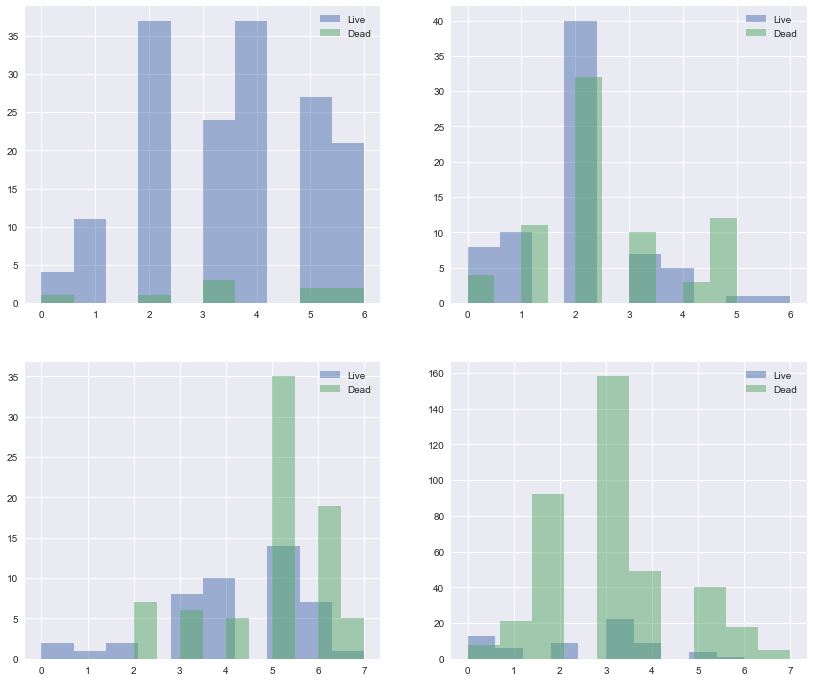

In [112]:
pltstr = "Age"
plt.clf()
plt.figure(figsize=(14,12))
for i in range(len(post_full_train)):
    plt.subplot(221 + i)
    post_full_train[i].loc[(post_full_train[i]['Survived'] == 1), pltstr].hist(alpha=0.5, label="Live")
    post_full_train[i].loc[(post_full_train[i]['Survived'] == 0), pltstr].hist(alpha=0.5, label="Dead")
    plt.legend()
plt.show()

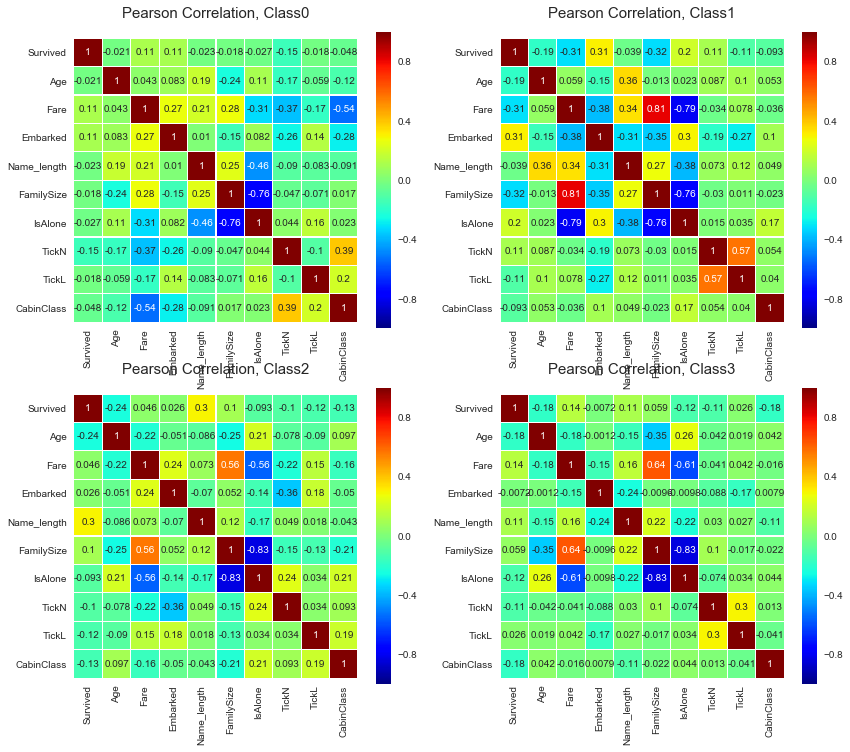

In [113]:
colormap = plt.cm.jet
plt.clf()
plt.figure(figsize=(14,12))
for i in range(len(post_full_train)):
    plt.subplot(221 + i )
    plt.title('Pearson Correlation, Class' + str(i), y=1.05, size=15)
    sns.heatmap(post_full_train[i].astype(float).corr(),linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

## Add in Ensembling; think of this as another feature engineering

In [146]:
# Put in our parameters for said classifiers
# Random Forest parameters
SEED = 24
rf_params = {
    'n_jobs': -1,
    'n_estimators': 30, 
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    'random_state' : SEED,
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':30,
    #'max_features': 0.5,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED,
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 30,
    'learning_rate' : 0.25,
    'random_state' : SEED,
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 30,
    'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED,
}

# Support Vector Classifier parameters 
svc_params = {'kernel' : 'linear','C' : 1, 'random_state' : SEED,}


# KNN Classifier parameters 
knn3_params = {'n_neighbors' : 3}
knn10_params = {'n_neighbors' : 10}
knn1_params = {'n_neighbors' : 1}

Training Class 0 is complete


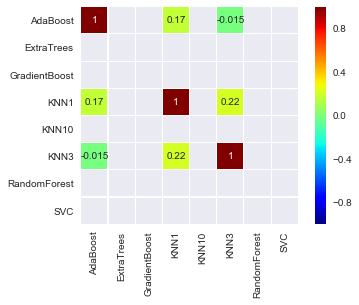

Training Class 1 is complete


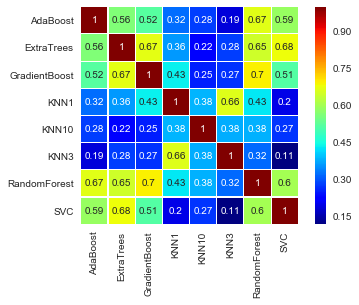

Training Class 2 is complete


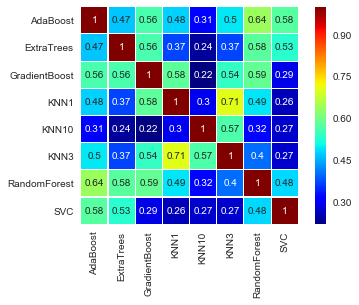

Training Class 3 is complete


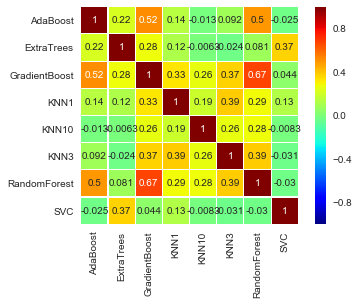

In [147]:
new_post_full_train = []
new_post_full_test = []

skmodels = {
    'RandomForest': (RandomForestClassifier, rf_params),
    'ExtraTrees': (ExtraTreesClassifier, et_params),
    'AdaBoost': (AdaBoostClassifier, ada_params),
    'GradientBoost': (GradientBoostingClassifier, gb_params),
    'SVC': (SVC, svc_params),
    'KNN3': (KNeighborsClassifier, knn3_params),
    'KNN1': (KNeighborsClassifier, knn1_params),
    'KNN10': (KNeighborsClassifier, knn10_params),
    }

for i in range(len(post_full_train)):
    
    ## clean up the train and test for models
    train = copy.deepcopy(post_full_train[i])
    test  =  copy.deepcopy(post_full_test[i])
    y_train  = train['Survived'].ravel()
    x_train  = train.drop(['Survived'], axis=1).values # Creates an array of the train data
    x_test   = test.values # Creats an array of the test data

    # Create objects that represent models
    predictions_train_dic = {}
    predictions_test_dic = {}
    
    for skname, skmodel in skmodels.items():
        temp_model = SklearnHelper(clf=skmodel[0], params=skmodel[1])
        temp_train, temp_test = get_oof(temp_model, x_train, y_train, x_test)
        predictions_train_dic[skname] = temp_train.ravel()
        predictions_test_dic[skname] = temp_test.ravel()
        
    print("Training Class %i is complete" % i)
    
    ##pack the outputs
    base_predictions_train = pd.DataFrame(predictions_train_dic, index=train.index)
    base_predictions_test = pd.DataFrame(predictions_test_dic, index=test.index)
    
    check_null([base_predictions_test, base_predictions_test])
    #base_predictions_train.head()
    
    plt.clf()
    sns.heatmap(base_predictions_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
                    square=True, cmap=colormap, linecolor='white', annot=True)
    plt.show()
    new_post_full_train.append(base_predictions_train)
    new_post_full_test.append(base_predictions_test)

    

(144, 10) (144, 8) (144, 18)
(122, 10) (122, 8) (122, 18)
(455, 10) (455, 8) (455, 18)


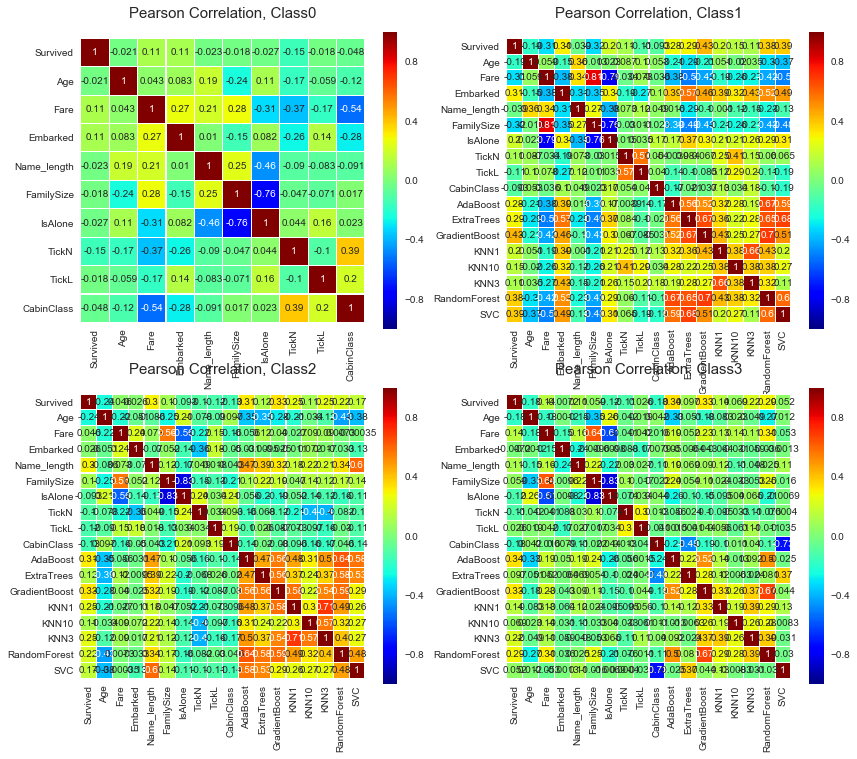

In [153]:
new_full_train = []
new_full_test = []
for i in range(len(post_full_train)):
    if i == 0: ##pass the woman 12 class
        new_full_train.append( post_full_train[i] )
        new_full_test.append( post_full_test[i])
    else:
        new_full_train.append( pd.concat([post_full_train[i], new_post_full_train[i]], axis=1)) 
        new_full_test.append( pd.concat([post_full_test[i], new_post_full_test[i]], axis=1))
        #new_full_train.append(  pd.concat([post_full_train[i]["Survived"], new_post_full_train[i]], axis=1)) 
        #new_full_test.append( new_post_full_test[i])
        print(post_full_train[i].shape, new_post_full_train[i].shape, new_full_train[i].shape)

colormap = plt.cm.jet
plt.clf()
plt.figure(figsize=(14,12))
for i in range(len(new_full_train)):
    plt.subplot(221 + i )
    plt.title('Pearson Correlation, Class' + str(i), y=1.05, size=15)
    sns.heatmap(new_full_train[i].astype(float).corr(),linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

## Let's XGboost and CV this

#### It is good to see upsample doesn't seem to help conclusively
* with upsample, 
    * class 0: ave 0.971 pm 0.041
    * class 3: ave 0.837 pm 0.031
* without upsample,
    * class 0: ave 0.956 pm 0.069
    * class 3: ave 0.922 pm 0.051

In [156]:
# ## Try to add up sampling; doesn't seem to help much...canont yield a confident gain
post_upsample_train = []
for i, df in enumerate(new_full_train):
    post_upsample_train.append(upsample_data(df))
    print("post:", post_upsample_train[i].shape, "pre:", new_full_train[i].shape)

post: (241, 10) pre: (170, 10)
post: (144, 18) pre: (144, 18)
post: (122, 18) pre: (122, 18)
post: (586, 18) pre: (455, 18)


In [162]:
##start with multiple models
xgb_models = {}
pred_results = {}
for i, df in enumerate(new_full_train):
#     if i != 1:
#         continue
    print("CLASS" + str(i) + "!!!")
    n_tests = 10 ##number of models to average over
    test_results = np.zeros(n_tests)
    pred_results[i] = np.zeros(new_full_test[i].shape[0])
    for j in range(n_tests):
        data = pack_data(df, SEED=j) ##convert df into train, test, feature
        xgb_models[i] = training(data, name="xgb_" + str(i), optimize=False)
        test_results[j] = evaluate(xgb_models[i], data)
        pred_results[i] += xgb_models[i].predict(new_full_test[i])
    #print(test_results)
    pred_results[i] /= n_tests
    print("ave %.3f pm %.3f" % (np.mean(test_results), np.std(test_results)))

CLASS0!!!
ave 0.967 pm 0.051
CLASS1!!!
ave 0.675 pm 0.139
CLASS2!!!
ave 0.714 pm 0.156
CLASS3!!!
ave 0.926 pm 0.044


In [163]:
# Generate Submission File 
predictions = []
for i, model in xgb_models.items():
    predictions.append(np.round(pred_results[i]).astype(int))
    #print(predictions[i].shape, full_test_ID[i].shape)
IDs = [item for sublist in full_test_ID for item in sublist]
preds = [item for sublist in predictions for item in sublist]
submit = pd.DataFrame({ 'PassengerId': IDs, 'Survived': preds }).sort_values("PassengerId")
print(submit.head())
submit.to_csv("Data/Submission.csv", index=False)

     PassengerId  Survived
209          892         0
80           893         0
210          894         0
211          895         0
81           896         1


## End

In [ ]:
##For other testing